# Self-Discover Agent

An implementation of the [Self-Discover paper](https://arxiv.org/pdf/2402.03620.pdf).

Based on [this implementation from @catid](https://github.com/catid/self-discover/tree/main?tab=readme-ov-file)


## Setup

First, let's install our required packages and set our API keys

In [12]:
%%capture --no-stderr
%pip install -U --quiet langchain langgraph langchain_openai

In [13]:
import getpass

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

load_dotenv()


def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)


import os

os.environ['DEEPSEEK_API_KEY'] = os.getenv("DEEPSEEK_API_KEY")


# _set_if_und、efined("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>   

## Define the prompts

In [1]:
from langchain import hub

select_prompt = hub.pull("hwchase17/self-discovery-select")
print("Self-Discovery Select Prompt**:")
select_prompt.pretty_print()
print("Self-Discovery Select Response**:")
adapt_prompt = hub.pull("hwchase17/self-discovery-adapt")
adapt_prompt.pretty_print()
structured_prompt = hub.pull("hwchase17/self-discovery-structure")
print("Self-Discovery Structured Prompt**:")
structured_prompt.pretty_print()
reasoning_prompt = hub.pull("hwchase17/self-discovery-reasoning")
print("Self-Discovery Structured Response**:")
reasoning_prompt.pretty_print()

E:\software\install_software\anaconda\envs\langchain-debug\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Self-Discovery Select Prompt**:
Select several reasoning modules that are crucial to utilize in order to solve the given task:

All reasoning module descriptions:
{reasoning_modules}

Task: {task_description}

Select several modules are crucial for solving the task above:

Self-Discovery Select Response**:


E:\software\install_software\anaconda\envs\langchain-debug\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Rephrase and specify each reasoning module so that it better helps solving the task:

SELECTED module descriptions:
{selected_modules}

Task: {task_description}

Adapt each reasoning module description to better solve the task:



E:\software\install_software\anaconda\envs\langchain-debug\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Self-Discovery Structured Prompt**:
Operationalize the reasoning modules into a step-by-step reasoning plan in JSON format:

Here's an example:

Example task:

If you follow these instructions, do you return to the starting point? Always face forward. Take 1 step backward. Take 9 steps left. Take 2 steps backward. Take 6 steps forward. Take 4 steps forward. Take 4 steps backward. Take 3 steps right.

Example reasoning structure:

{
    "Position after instruction 1":
    "Position after instruction 2":
    "Position after instruction n":
    "Is final position the same as starting position":
}

Adapted module description:
{adapted_modules}

Task: {task_description}

Implement a reasoning structure for solvers to follow step-by-step and arrive at correct answer.

Note: do NOT actually arrive at a conclusion in this pass. Your job is to generate a PLAN so that in the future you can fill it out and arrive at the correct conclusion for tasks like this


E:\software\install_software\anaconda\envs\langchain-debug\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Self-Discovery Structured Response**:
Follow the step-by-step reasoning plan in JSON to correctly solve the task. Fill in the values following the keys by reasoning specifically about the task given. Do not simply rephrase the keys.
    
Reasoning Structure:
{reasoning_structure}

Task: {task_description}


## Define the graph

In [15]:
from typing import Optional
from typing_extensions import TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

from langgraph.graph import END, START, StateGraph


class SelfDiscoverState(TypedDict):
    reasoning_modules: str
    task_description: str
    selected_modules: Optional[str]
    adapted_modules: Optional[str]
    reasoning_structure: Optional[str]
    answer: Optional[str]


# model = ChatOpenAI(temperature=0, model="gpt-4-turbo-preview")
model = ChatOpenAI(
    model="deepseek-chat",  # DeepSeek的聊天模型
    temperature=0,
    openai_api_key=os.getenv("DEEPSEEK_API_KEY"),  # 从DeepSeek获取的API key
    openai_api_base="https://api.deepseek.com/v1"  # DeepSeek的Base URL
)

def select(inputs):
    select_chain = select_prompt | model | StrOutputParser()
    return {"selected_modules": select_chain.invoke(inputs)}


def adapt(inputs):
    adapt_chain = adapt_prompt | model | StrOutputParser()
    return {"adapted_modules": adapt_chain.invoke(inputs)}


def structure(inputs):
    structure_chain = structured_prompt | model | StrOutputParser()
    return {"reasoning_structure": structure_chain.invoke(inputs)}


def reason(inputs):
    reasoning_chain = reasoning_prompt | model | StrOutputParser()
    return {"answer": reasoning_chain.invoke(inputs)}


graph = StateGraph(SelfDiscoverState)
graph.add_node(select)
graph.add_node(adapt)
graph.add_node(structure)
graph.add_node(reason)
graph.add_edge(START, "select")
graph.add_edge("select", "adapt")
graph.add_edge("adapt", "structure")
graph.add_edge("structure", "reason")
graph.add_edge("reason", END)
app = graph.compile()

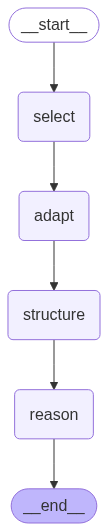

In [20]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## Invoke the graph

In [ ]:
reasoning_modules = [
    "1. How could I devise an experiment to help solve that problem?",
    "2. Make a list of ideas for solving this problem, and apply them one by one to the problem to see if any progress can be made.",
    # "3. How could I measure progress on this problem?",
    "4. How can I simplify the problem so that it is easier to solve?",
    "5. What are the key assumptions underlying this problem?",
    "6. What are the potential risks and drawbacks of each solution?",
    "7. What are the alternative perspectives or viewpoints on this problem?",
    "8. What are the long-term implications of this problem and its solutions?",
    "9. How can I break down this problem into smaller, more manageable parts?",
    "10. Critical Thinking: This style involves analyzing the problem from different perspectives, questioning assumptions, and evaluating the evidence or information available. It focuses on logical reasoning, evidence-based decision-making, and identifying potential biases or flaws in thinking.",
    "11. Try creative thinking, generate innovative and out-of-the-box ideas to solve the problem. Explore unconventional solutions, thinking beyond traditional boundaries, and encouraging imagination and originality.",
    # "12. Seek input and collaboration from others to solve the problem. Emphasize teamwork, open communication, and leveraging the diverse perspectives and expertise of a group to come up with effective solutions.",
    "13. Use systems thinking: Consider the problem as part of a larger system and understanding the interconnectedness of various elements. Focuses on identifying the underlying causes, feedback loops, and interdependencies that influence the problem, and developing holistic solutions that address the system as a whole.",
    "14. Use Risk Analysis: Evaluate potential risks, uncertainties, and tradeoffs associated with different solutions or approaches to a problem. Emphasize assessing the potential consequences and likelihood of success or failure, and making informed decisions based on a balanced analysis of risks and benefits.",
    # "15. Use Reflective Thinking: Step back from the problem, take the time for introspection and self-reflection. Examine personal biases, assumptions, and mental models that may influence problem-solving, and being open to learning from past experiences to improve future approaches.",
    "16. What is the core issue or problem that needs to be addressed?",
    "17. What are the underlying causes or factors contributing to the problem?",
    "18. Are there any potential solutions or strategies that have been tried before? If yes, what were the outcomes and lessons learned?",
    "19. What are the potential obstacles or challenges that might arise in solving this problem?",
    "20. Are there any relevant data or information that can provide insights into the problem? If yes, what data sources are available, and how can they be analyzed?",
    "21. Are there any stakeholders or individuals who are directly affected by the problem? What are their perspectives and needs?",
    "22. What resources (financial, human, technological, etc.) are needed to tackle the problem effectively?",
    "23. How can progress or success in solving the problem be measured or evaluated?",
    "24. What indicators or metrics can be used?",
    "25. Is the problem a technical or practical one that requires a specific expertise or skill set? Or is it more of a conceptual or theoretical problem?",
    "26. Does the problem involve a physical constraint, such as limited resources, infrastructure, or space?",
    "27. Is the problem related to human behavior, such as a social, cultural, or psychological issue?",
    "28. Does the problem involve decision-making or planning, where choices need to be made under uncertainty or with competing objectives?",
    "29. Is the problem an analytical one that requires data analysis, modeling, or optimization techniques?",
    "30. Is the problem a design challenge that requires creative solutions and innovation?",
    "31. Does the problem require addressing systemic or structural issues rather than just individual instances?",
    "32. Is the problem time-sensitive or urgent, requiring immediate attention and action?",
    "33. What kinds of solution typically are produced for this kind of problem specification?",
    "34. Given the problem specification and the current best solution, have a guess about other possible solutions."
    "35. Let’s imagine the current best solution is totally wrong, what other ways are there to think about the problem specification?"
    "36. What is the best way to modify this current best solution, given what you know about these kinds of problem specification?"
    "37. Ignoring the current best solution, create an entirely new solution to the problem."
    # "38. Let’s think step by step."
    "39. Let’s make a step by step plan and implement it with good notation and explanation.",
]

task_example = "Lisa has 10 apples. She gives 3 apples to her friend and then buys 5 more apples from the store. How many apples does Lisa have now?"

task_example = """This SVG path element <path d="M 55.57,80.69 L 57.38,65.80 M 57.38,65.80 L 48.90,57.46 M 48.90,57.46 L
45.58,47.78 M 45.58,47.78 L 53.25,36.07 L 66.29,48.90 L 78.69,61.09 L 55.57,80.69"/> draws a:
(A) circle (B) heptagon (C) hexagon (D) kite (E) line (F) octagon (G) pentagon(H) rectangle (I) sector (J) triangle"""

reasoning_modules_str = "\n".join(reasoning_modules)

for s in app.stream(
        {"task_description": task_example, "reasoning_modules": reasoning_modules_str}
):
    print(s)

{'select': {'selected_modules': "To solve the task of identifying the shape drawn by the given SVG path element, the following reasoning modules are crucial:\n\n1. **How can I break down this problem into smaller, more manageable parts? (Module 9)**  \n   - The SVG path consists of multiple line segments. Breaking it down into individual segments and analyzing their connections will help understand the overall shape.\n\n2. **What are the key assumptions underlying this problem? (Module 5)**  \n   - Assumptions might include that the path is closed (if it forms a shape) or open (if it's a line), and that the coordinates define vertices of a polygon or a continuous path.\n\n3. **Critical Thinking (Module 10)**  \n   - Analyze the coordinates to determine if the path forms a closed shape, count the number of distinct vertices, and compare with the options provided (e.g., hexagon, pentagon, line).\n\n4. **What kinds of solution typically are produced for this kind of problem specification?